## **Data Mining Project - Deliverable 2**

Done by:

Student Name 1: Catarina Mendinhas   
Student ID 1: 20250422

Student Name 2: Bárbara Franco  
Student ID 2: 20250388

Student Name 3: Khadija Ennaifer   
Student ID 3: 20250439

## **Table of Contents**

**[0. Context and Metadata](#0-context-and-metadata)**

**[1. Importing Libraries, Loading and Reading Data](#1-importing-libraries-loading-and-reading-data)**

**[2. Deep Embedded Clustering: Autoencoders](#2-deep-embedded-clustering:-autoencoders)**  
- [2.1 Multi-perspective Segmentation ](#21-multi-perspective-segmentation)
- [2.2 Autoencoder](#22-autoencoder)

**[3. Visualizations](#3-visualizations)**
- [3.1 All Customers](#31-all-customers)
    - [3.1.1 Value Segmentation](#311-value-segmentation)
    - [3.1.2 Behavioral Segmentation](#312-behavioral-segmentation)
- [3.2 Active Customers](#31-active-customers)
    - [3.2.1 Value Segmentation](#321-value-segmentation)
    - [3.2.2 Behavioral Segmentation](#322-behavioral-segmentation)


<a class="anchor" id="0">

## **0. Context and Metadata**

[Back to TOP](#TOP)
</a>

AIAI Loyalty Program customer segmentation was initiated to improve customer retention and engagement through targeted marketing strategies. Initially, traditional clustering algorithms were explored; however, these are limited by cluster shape, sensitivity to dimensionality, noise and distance metrics. These limitations are really relevant in customer segmentation tasks that rely on high-dimensional features, where meaningful customer similarities may not be captured correctly in the original feature space. A Deep Embedded Clustering (DEC) was adopted to overcome these difficulties.

**Metadata**

**CustomerDB:**
- `Loyalty#` : Unique customer identifier for loyalty program members;
- `First Name` : Customer's first name;
- `Last Name` : Customer's last name;
- `Customer Name` : Customer's full name (concatenated);
- `Country` : Customer's country of residence;
- `Province or State` : Customer's province or state;
- `City` : Customer's city of residence;
- `Latitude` : Geographic latitude coordinate of customer location;
- `Longitude` : Geographic longitude coordinate of customer location;
- `Postal code` : Customer's postal/ZIP code;
- `Gender` : Customer's gender;
- `Education` : Customer's highest education level (Bachelor, College, etc.);
- `Location Code` : Urban/Suburban/Rural classification of customer residence;
- `Income` : Customer's annual income;
- `Marital Status` : Customer's marital status (Married, Single, Divorced);
- `LoyaltyStatus` : Current tier status in loyalty program (Star > Nova > Aurora);
- `EnrollmentDateOpening` : Date when customer joined the loyalty program;
- `CancellationDate` : Date when customer left the program;
- `Customer Lifetime Value` : Total calculated monetary value of customer relationship;
- `EnrollmentType` : Method of joining loyalty program;

**FlightsDB:**
- `Loyalty#` : Unique customer identifier linking to CustomerDB;
- `Year` : Year of flight activity record;
- `Month` : Month of flight activity record (1-12);
- `YearMonthDate` : First day of the month for the activity period;
- `NumFlights` : Total number of flights taken by customer in the month;
- `NumFlightsWithCompanions` : Number of flights where customer traveled with companions;
- `DistanceKM` : Total distance traveled in kilometers for the month;
- `PointsAccumulated` : Loyalty points earned by customer during the month;
- `PointsRedeemed` : Loyalty points spent/redeemed by customer during the month;
- `DollarCostPointsRedeemed` : Dollar value of points redeemed during the month;

<a class="anchor" id="1">

## **1. Importing Libraries, Loading and Reading Data**

[Back to TOP](#TOP)
</a>

In [1]:
#!pip install torch; umap-learn; plotly

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from dateutil.relativedelta import relativedelta
from math import ceil

# Metrics to evaluate kmeans clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples

# For Color Maps and Visualizations
from matplotlib import colors as mpl_colors
from matplotlib import colorbar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, to_hex
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For Autoencoder
from typing import Tuple
from torch import nn
from torch import Tensor
import torch
from torch.utils.data import DataLoader, TensorDataset

# Cluster Vizualizations
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.io as pio

# Additional functions created for this project
from functions import *

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [3]:
df_all = pd.read_csv('df_all_for_clustering.csv')
df_active = pd.read_csv('df_active_for_clustering.csv')

In [4]:
df_all.set_index('Loyalty#', inplace=True)
df_active.set_index('Loyalty#', inplace=True)

<a class="anchor" id="2">

## **2. Deep Embedded Clustering: Autoencoders**

[Back to TOP](#TOP)
</a>

<a class="anchor" id="2.1">

### **2.1 Multi-perspective segmentation**

[Back to TOP](#TOP)
</a>

We will divide our features into two segments. One is value based, meaning that it brings economic value to the company. And another based on the behaviour of the customers. We did not find enough numerical features to create a demographic segmentation. The division is the following:

In [5]:
value_segmentation = ['Customer Lifetime Value', 'PropCLV', 'TotalPoints', 'PropPoints', 'Months_Since_Enrollment']
behavioral_segmentation = ['Recency_Months', 'NumFlights_Max', 'NumFlightsWithCompanions_Max', 'Ratio_Flights_Companions', 'Ratio_Points_Redeemed', 'PropNrFlights', 'PropNrFlightsWithCompanions', 'MeanDistancePerFlight', 'DiversitySeason']

For this project we will do 2 works in parallel:  

- Use all customers in the clustering algorithms and check if they are able to group all the customers that have cancelled without the variable 'ChurnStatus'. If this happens, we will consider that the other customers that were grouped with the cancelled ones, are at risk of churn. Then we will remove the ones that have cancelled customers from the cluster.
 They are helpful to identify the patterns of the clients that have a high probability of leaving the program, however, we do not wish to create a marketing strategy for them as the goal is only to do so for customers in the program.

- Use only the active customers for the clustering and after, in profilling, we will analyse if there is any cluster with similar characteristics to the clients that already left the program.




<a class="anchor" id="2.2">

### **2.2 Autoencoder**

[Back to TOP](#TOP)
</a>

Train an autoencoder for unsupervised learning. It learns a compact latent representation which is later used for clustering

Use the encoder to transform each example in a small vector, Z

Perform K-Means in Z

Based on the following link but simplified to be applicable to our project: https://github.com/tschechlovdev/AutoEncoder_KMeans/blob/main/AutoEncoder_KMeans_MNIST.ipynb

In [6]:
# the results have do be saved either on GPU or CPU depending on the availability, but not both
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#### **All Customers**

**Value-Based Segmentation**

In [7]:
results_all_val, best_all_val, labels_all_val = deep_kmeans_search(
    df=df_all,
    features=value_segmentation,
    device = device,
    k_list=[3,4,5,6],
    latent_list=[2,3,5,8],
    hidden_dim=32,
    lr=1e-3,
    batch_size=256,
    epochs=60,
    random_state=1,
)

display(results_all_val.sort_values(["model","silhouette"], ascending=[True, False]).head(15))
print({k: best_all_val[k] for k in ["k","latent_dim","ae_loss","score", "r2"]})

model  k  latent_dim  train_loss  silhouette        r2
5   AE+KMeans_Z  4         2.0    0.060750    0.575739  0.446172
6   AE+KMeans_Z  5         2.0    0.060750    0.570322  0.452669
4   AE+KMeans_Z  3         2.0    0.060750    0.547945  0.434539
12  AE+KMeans_Z  3         5.0    0.000367    0.472755  0.434661
16  AE+KMeans_Z  3         8.0    0.000233    0.450456  0.454005
7   AE+KMeans_Z  6         2.0    0.060750    0.412322  0.571425
17  AE+KMeans_Z  4         8.0    0.000233    0.408979  0.541910
13  AE+KMeans_Z  4         5.0    0.000367    0.393218  0.529903
10  AE+KMeans_Z  5         3.0    0.001693    0.331078  0.619864
19  AE+KMeans_Z  6         8.0    0.000233    0.329603  0.654671
15  AE+KMeans_Z  6         5.0    0.000367    0.318142  0.648572
18  AE+KMeans_Z  5         8.0    0.000233    0.316714  0.614263
11  AE+KMeans_Z  6         3.0    0.001693    0.309321  0.676797
14  AE+KMeans_Z  5         5.0    0.000367    0.308950  0.581626
9   AE+KMeans_Z  4         3.0    0.001693    0.307456  0.510479

{'k': 4, 'latent_dim': 2, 'ae_loss': 0.06075022291324229, 'score': 0.5757385492324829, 'r2': np.float64(0.44617238504342194)}


We will consider as possible candidates the trials with silhouette higher than 0.30 and from those choose the one with the higher R² score. We will use this criteria for the other cases. In this case the best option is the row with index 11.

In [8]:
row_all_val = results_all_val.loc[11]
aekmeans_labels_all_val = labels_all_val[11]

In [9]:
row_all_val.to_dict()

{'model': 'AE+KMeans_Z',
 'k': 6,
 'latent_dim': 3.0,
 'train_loss': 0.0016929975272257404,
 'silhouette': 0.3093213737010956,
 'r2': 0.676796941409517}

In [10]:
pd.Series(aekmeans_labels_all_val).value_counts().sort_index()

0    3786
1    3503
2    1573
3    1535
4    3670
5     920
Name: count, dtype: int64

{'model': 'AE+KMeans_Z',
 'k': 6,
 'latent_dim': 3.0}

 These are the best parameters

**Save labels for original space**

In [11]:
display(results_all_val.sort_values(["model"], ascending=[False]).head(4))

model  k  latent_dim  train_loss  silhouette        r2
0  KMeans_X  3         NaN         NaN    0.387116  0.469828
2  KMeans_X  5         NaN         NaN    0.279123  0.639053
3  KMeans_X  6         NaN         NaN    0.295260  0.692326
1  KMeans_X  4         NaN         NaN    0.358761  0.563192

In [12]:
row_all_val_X = results_all_val.loc[3]
aekmeans_labels_all_val_X = labels_all_val[3]

**Behavioral Segmentation**

In [13]:
results_all_beh, best_all_beh, labels_all_beh = deep_kmeans_search(
    df=df_all,
    features=behavioral_segmentation,
    device = device,
    k_list=[3,4,5,6],
    latent_list=[2,3,5,8],
    hidden_dim=32,
    lr=1e-3,
    batch_size=256,
    epochs=60,
    random_state=1)

display(results_all_beh.sort_values(["model","silhouette"], ascending=[True, False]).head(15))
print({k: best_all_beh[k] for k in ["k","latent_dim","ae_loss","score", "r2"]})

model  k  latent_dim  train_loss  silhouette        r2
12  AE+KMeans_Z  3         5.0    0.035033    0.577629  0.252375
6   AE+KMeans_Z  5         2.0    0.185351    0.507107  0.355152
5   AE+KMeans_Z  4         2.0    0.185351    0.486111  0.236533
4   AE+KMeans_Z  3         2.0    0.185351    0.377515  0.232065
7   AE+KMeans_Z  6         2.0    0.185351    0.326987  0.415388
8   AE+KMeans_Z  3         3.0    0.125834    0.303107  0.265675
9   AE+KMeans_Z  4         3.0    0.125834    0.301468  0.322799
10  AE+KMeans_Z  5         3.0    0.125834    0.268670  0.393003
16  AE+KMeans_Z  3         8.0    0.000681    0.246714  0.323000
11  AE+KMeans_Z  6         3.0    0.125834    0.243972  0.420598
17  AE+KMeans_Z  4         8.0    0.000681    0.242215  0.363129
18  AE+KMeans_Z  5         8.0    0.000681    0.238441  0.401420
14  AE+KMeans_Z  5         5.0    0.035033    0.196899  0.374642
15  AE+KMeans_Z  6         5.0    0.035033    0.194542  0.436345
13  AE+KMeans_Z  4         5.0    0.035033    0.191848  0.337771

{'k': 3, 'latent_dim': 5, 'ae_loss': 0.03503300140504881, 'score': 0.5776294469833374, 'r2': np.float64(0.25237495616359285)}


In [14]:
# the best choice is the row with index 11
row_all_beh = results_all_beh.loc[11]
aekmeans_labels_all_beh = labels_all_beh[11]

In [15]:
row_all_beh.to_dict()

{'model': 'AE+KMeans_Z',
 'k': 6,
 'latent_dim': 3.0,
 'train_loss': 0.12583404381476657,
 'silhouette': 0.24397173523902893,
 'r2': 0.4205982678279092}

In [16]:
pd.Series(aekmeans_labels_all_beh).value_counts().sort_index()

0    3342
1    3458
2    4889
3     439
4     990
5    1869
Name: count, dtype: int64

{'model': 'AE+KMeans_Z',
 'k': 6,
 'latent_dim': 3.0}

This set of parameters provides the best results

**Save labels for original space**

In [17]:
display(results_all_beh.sort_values(["model"], ascending=[False]).head(4))

model  k  latent_dim  train_loss  silhouette        r2
0  KMeans_X  3         NaN         NaN    0.186438  0.350331
2  KMeans_X  5         NaN         NaN    0.186467  0.478105
3  KMeans_X  6         NaN         NaN    0.187254  0.515589
1  KMeans_X  4         NaN         NaN    0.198457  0.422472

In [18]:
row_all_beh_X = results_all_beh.loc[3]
aekmeans_labels_all_beh_X = labels_all_beh[3]

#### **Active Customers**

**Value-Based Segmentation**

In [19]:
results_act_val, best_act_val, labels_act_val = deep_kmeans_search(
    df=df_active,
    features=value_segmentation,
    device = device,
    k_list=[3,4,5,6],
    latent_list=[2,3,5,8],
    hidden_dim=32,
    lr=1e-3,
    batch_size=256,
    epochs=60,
    random_state=1)

display(results_act_val.sort_values(["model","silhouette"], ascending=[True, False]).head(15))
print({k: best_act_val[k] for k in ["k","latent_dim","ae_loss","score", "r2"]})

model  k  latent_dim  train_loss  silhouette        r2
4   AE+KMeans_Z  3         2.0    0.059843    0.618664  0.404155
12  AE+KMeans_Z  3         5.0    0.000380    0.492184  0.445966
6   AE+KMeans_Z  5         2.0    0.059843    0.428844  0.562878
5   AE+KMeans_Z  4         2.0    0.059843    0.419603  0.524514
7   AE+KMeans_Z  6         2.0    0.059843    0.413493  0.597947
10  AE+KMeans_Z  5         3.0    0.000533    0.367917  0.575167
17  AE+KMeans_Z  4         8.0    0.000251    0.358366  0.537336
9   AE+KMeans_Z  4         3.0    0.000533    0.348038  0.448736
8   AE+KMeans_Z  3         3.0    0.000533    0.339752  0.411650
16  AE+KMeans_Z  3         8.0    0.000251    0.337490  0.409452
14  AE+KMeans_Z  5         5.0    0.000380    0.333729  0.581542
13  AE+KMeans_Z  4         5.0    0.000380    0.329436  0.540318
11  AE+KMeans_Z  6         3.0    0.000533    0.326585  0.660483
19  AE+KMeans_Z  6         8.0    0.000251    0.324700  0.661252
15  AE+KMeans_Z  6         5.0    0.000380    0.316136  0.655217

{'k': 3, 'latent_dim': 2, 'ae_loss': 0.059842796950182554, 'score': 0.6186642050743103, 'r2': np.float64(0.4041553716574088)}


In [20]:
# Again row 11 is the best one
row_act_val = results_act_val.loc[11]
aekmeans_labels_act_val = labels_act_val[11]

In [21]:
pd.Series(aekmeans_labels_act_val).value_counts().sort_index()

0    4132
1    3839
2    1477
3     430
4    2920
5     913
Name: count, dtype: int64

In [22]:
row_act_val.to_dict()

{'model': 'AE+KMeans_Z',
 'k': 6,
 'latent_dim': 3.0,
 'train_loss': 0.0005328739143843971,
 'silhouette': 0.32658466696739197,
 'r2': 0.6604828729641072}

{'model': 'AE+KMeans_Z',
 'k': 6,
 'latent_dim': 3.0}

  This set of parameters provides the best results.

**Save labels for original space**

In [23]:
display(results_act_val.sort_values(["model"], ascending=[False]).head(4))

model  k  latent_dim  train_loss  silhouette        r2
0  KMeans_X  3         NaN         NaN    0.394005  0.459419
2  KMeans_X  5         NaN         NaN    0.299070  0.637442
3  KMeans_X  6         NaN         NaN    0.293228  0.685797
1  KMeans_X  4         NaN         NaN    0.296764  0.572324

In [24]:
row_act_val_X = results_act_val.loc[3]
aekmeans_labels_act_val_X = labels_act_val[3]

**Behavioral Segmentation**

In [25]:
results_act_beh, best_act_beh, labels_act_beh = deep_kmeans_search(
    df=df_active,
    features=behavioral_segmentation,
    device = device,
    k_list=[3,4,5,6],
    latent_list=[2,3,5,8],
    hidden_dim=32,
    lr=1e-3,
    batch_size=256,
    epochs=60,
    random_state=1)

display(results_act_beh.sort_values(["model","silhouette"], ascending=[True, False]).head(15))
print({k: best_act_beh[k] for k in ["k","latent_dim","ae_loss","score", "r2"]})

model  k  latent_dim  train_loss  silhouette        r2
5   AE+KMeans_Z  4         2.0    0.164991    0.375078  0.392586
7   AE+KMeans_Z  6         2.0    0.164991    0.354677  0.498970
4   AE+KMeans_Z  3         2.0    0.164991    0.350919  0.336541
6   AE+KMeans_Z  5         2.0    0.164991    0.350243  0.435438
9   AE+KMeans_Z  4         3.0    0.103997    0.336264  0.390888
8   AE+KMeans_Z  3         3.0    0.103997    0.327055  0.336885
11  AE+KMeans_Z  6         3.0    0.103997    0.285820  0.496747
10  AE+KMeans_Z  5         3.0    0.103997    0.273254  0.441800
16  AE+KMeans_Z  3         8.0    0.000727    0.203782  0.317480
13  AE+KMeans_Z  4         5.0    0.023352    0.191289  0.351602
12  AE+KMeans_Z  3         5.0    0.023352    0.187760  0.302443
15  AE+KMeans_Z  6         5.0    0.023352    0.183991  0.439730
14  AE+KMeans_Z  5         5.0    0.023352    0.181435  0.408939
17  AE+KMeans_Z  4         8.0    0.000727    0.173044  0.358282
18  AE+KMeans_Z  5         8.0    0.000727    0.171853  0.405720

{'k': 4, 'latent_dim': 2, 'ae_loss': 0.16499109536107245, 'score': 0.3750784993171692, 'r2': np.float64(0.39258608188529986)}


In [26]:
# This time row 6 shows the best results (we are choosing a threshold of 0.30 for silhouette score)
row_act_beh = results_act_beh.loc[6]
aekmeans_labels_act_beh = labels_act_beh[6]

In [27]:
pd.Series(aekmeans_labels_act_beh).value_counts().sort_index()

0    6585
1     383
2    2511
3    3795
4     437
Name: count, dtype: int64

In [28]:
row_act_beh.to_dict()

{'model': 'AE+KMeans_Z',
 'k': 5,
 'latent_dim': 2.0,
 'train_loss': 0.16499109536107245,
 'silhouette': 0.3502434492111206,
 'r2': 0.43543822628281126}

{'model': 'AE+KMeans_Z',
 'k': 5,
 'latent_dim': 2.0}

Is the best set of parameters in this case

**Save labels for original space**

In [29]:
display(results_act_beh.sort_values(["model"], ascending=[False]).head(4))

model  k  latent_dim  train_loss  silhouette        r2
0  KMeans_X  3         NaN         NaN    0.204277  0.344178
2  KMeans_X  5         NaN         NaN    0.194100  0.469713
3  KMeans_X  6         NaN         NaN    0.164591  0.511541
1  KMeans_X  4         NaN         NaN    0.190045  0.418917

In [30]:
row_act_beh_X = results_act_beh.loc[2]
aekmeans_labels_act_beh_X = labels_act_beh[2]

<a class="anchor" id="3.1">

## **3 Visualizations**

[Back to TOP](#TOP)
</a>

<a class="anchor" id="3.1">

### **3.1. All Customers**

[Back to TOP](#TOP)
</a>

<a class="anchor" id="3.2.1">

#### **3.1.1 Value Segmentation**

[Back to TOP](#TOP)
</a>

In [31]:
tsne = TSNE(n_components=2, random_state=1, perplexity=30, max_iter=1000, learning_rate='auto', init='random')
tsne_data = tsne.fit_transform(df_all[value_segmentation])

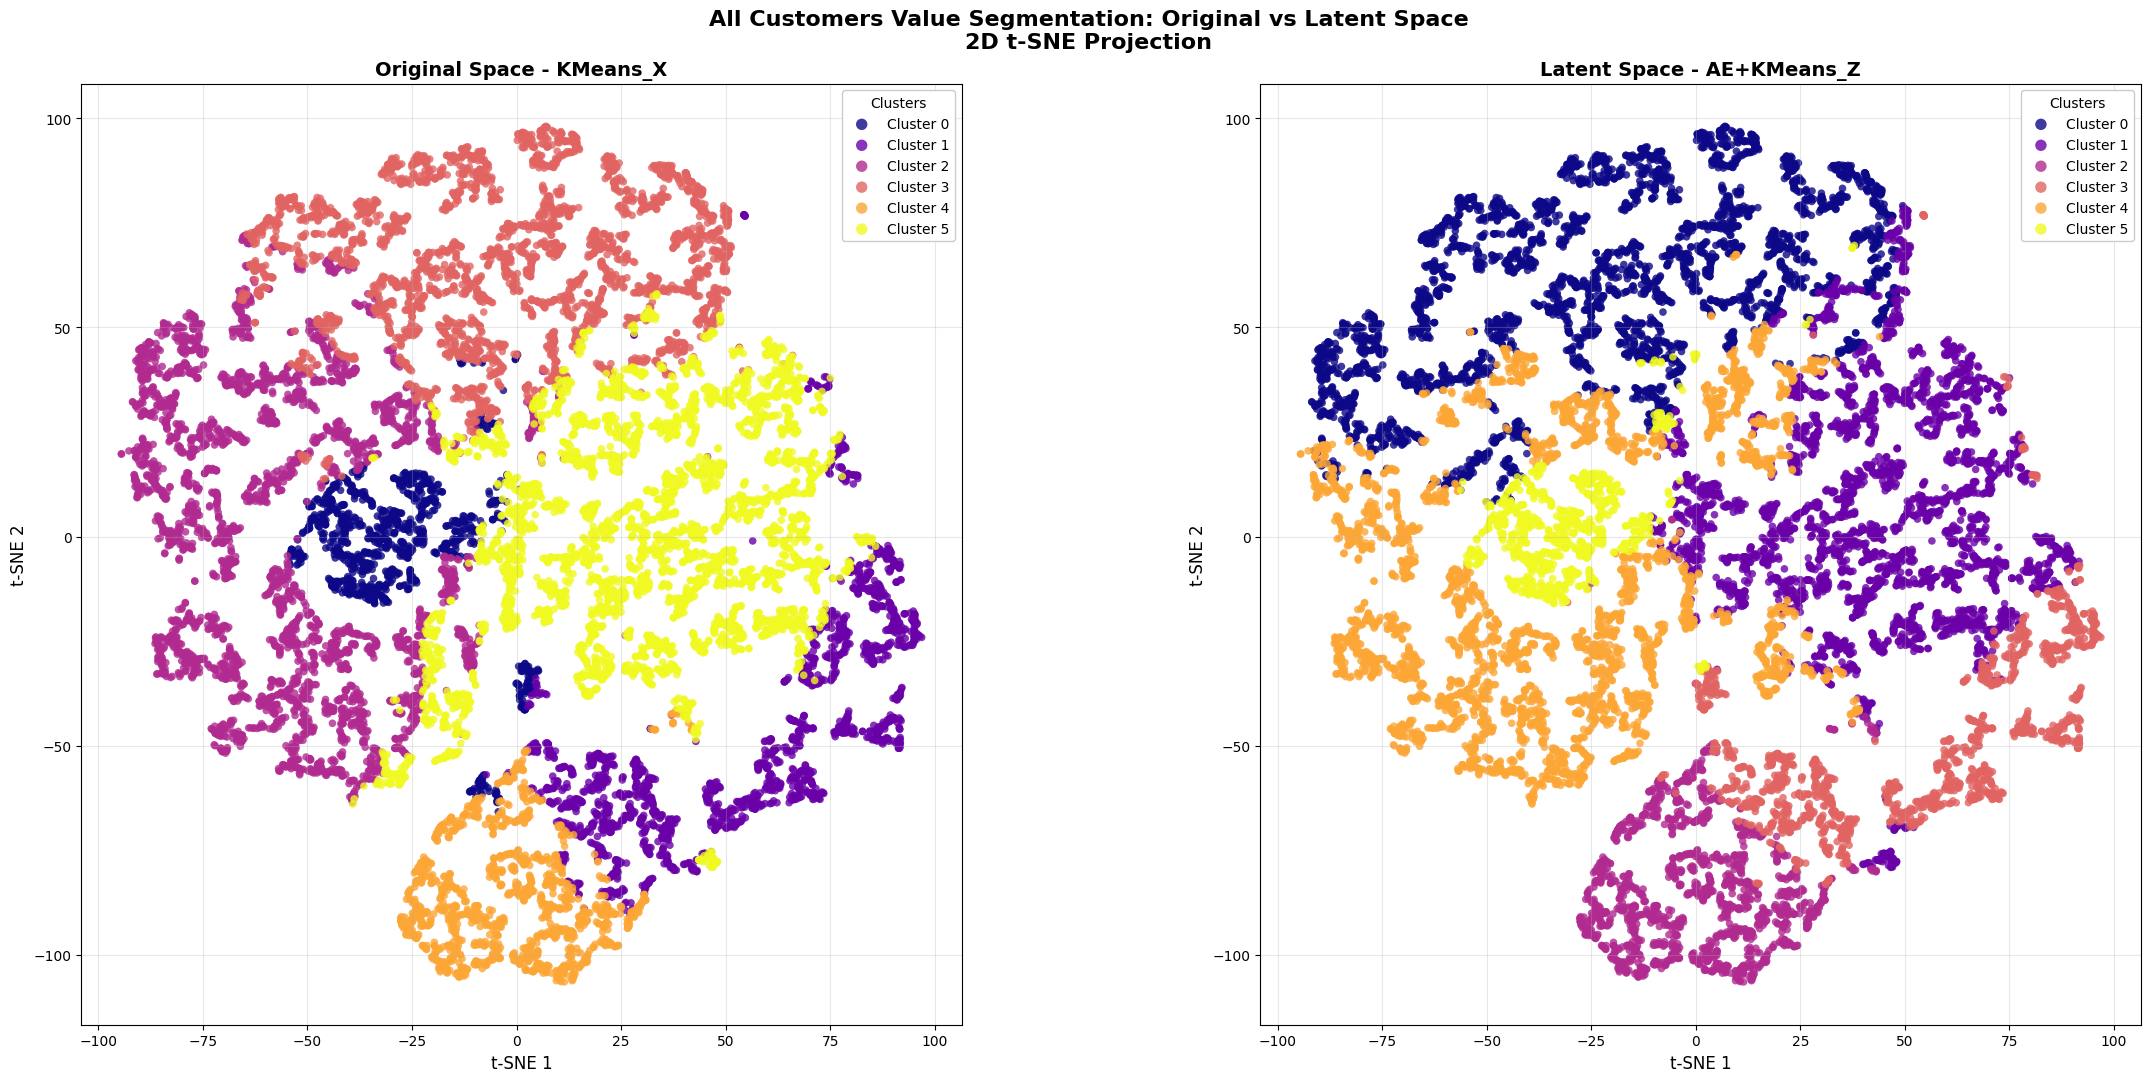

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(24, 11))

colors = cm.plasma(np.linspace(0, 1, 6))

# --- KMeans_X ---
for label in sorted(np.unique(aekmeans_labels_all_val_X)):
    mask = aekmeans_labels_all_val_X == label
    axes[0].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('t-SNE 1', fontsize=12)
axes[0].set_ylabel('t-SNE 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X', fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z ---
for label in sorted(np.unique(aekmeans_labels_all_val)):
    mask = aekmeans_labels_all_val == label
    axes[1].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('t-SNE 1', fontsize=12)
axes[1].set_ylabel('t-SNE 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Latent Space - AE+KMeans_Z', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('All Customers Value Segmentation: Original vs Latent Space\n2D t-SNE Projection', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [34]:
umap_2d = UMAP(n_components = 2 , init = 'random', n_neighbors = 50, random_state = 1)
umap_2d_data = umap_2d.fit_transform(df_all[value_segmentation])

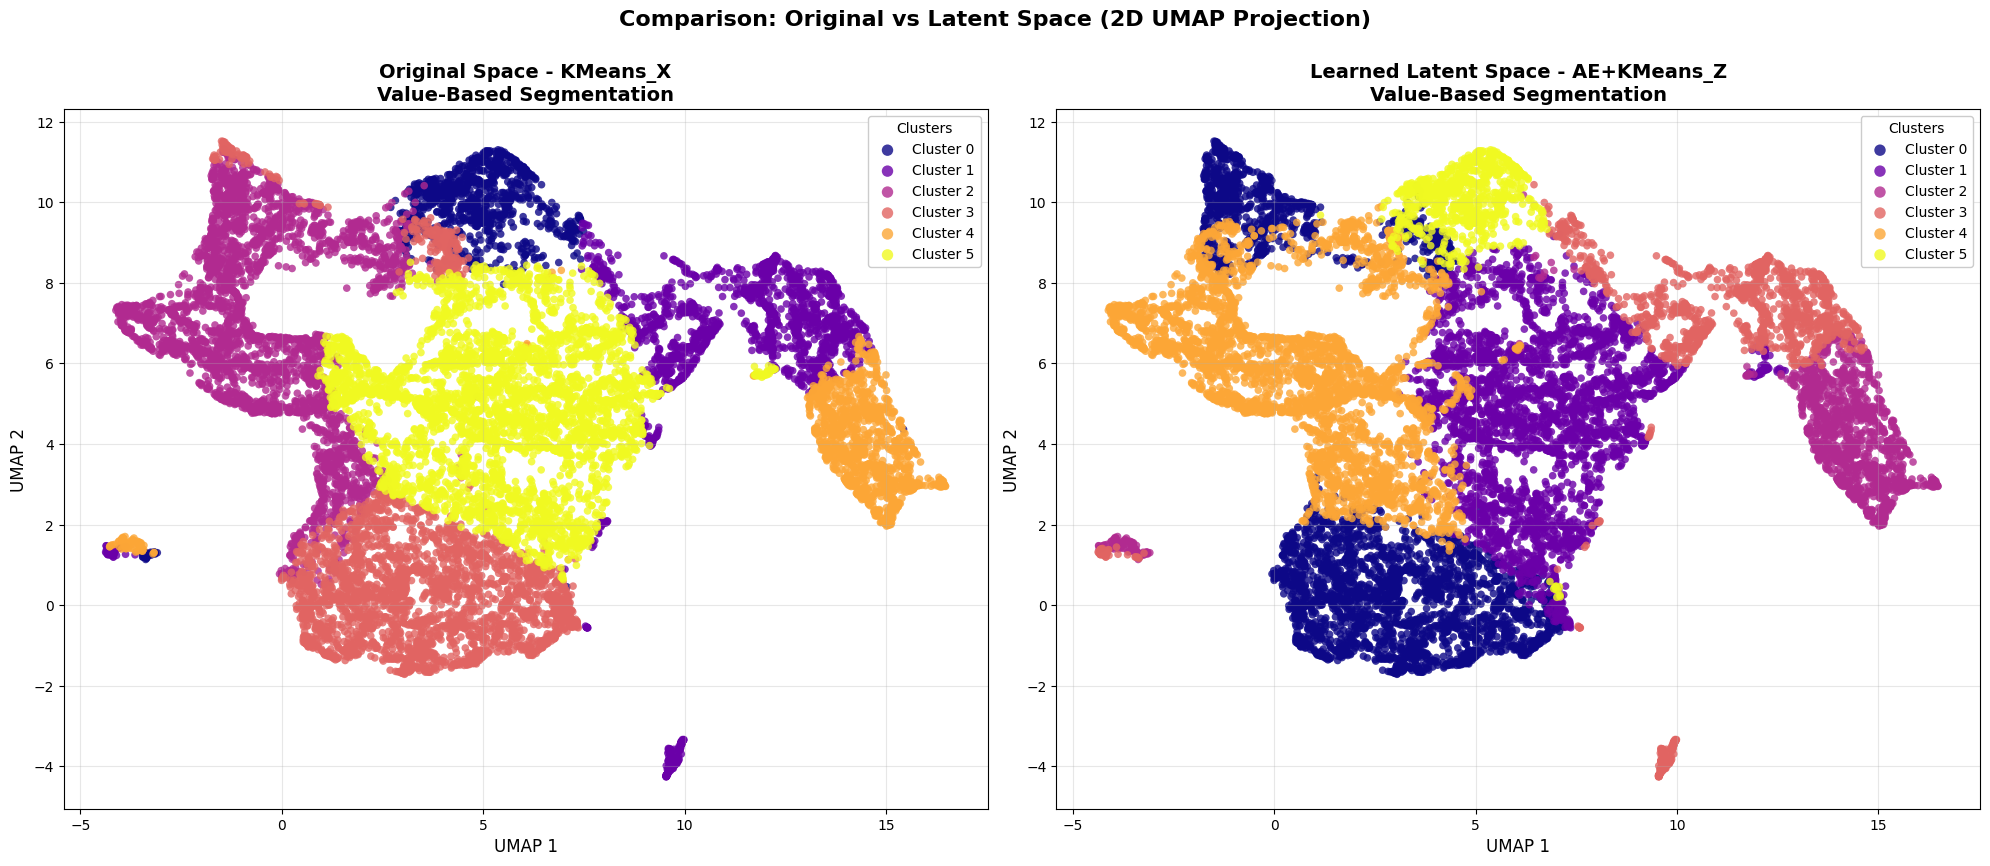

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# --- KMeans_X (Original Space) ---
for label in sorted(np.unique(aekmeans_labels_all_val_X)):
    mask = aekmeans_labels_all_val_X == label
    axes[0].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X\nValue-Based Segmentation', 
                 fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z (Latent Space) ---
for label in sorted(np.unique(aekmeans_labels_all_val)):
    mask = aekmeans_labels_all_val == label
    axes[1].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Learned Latent Space - AE+KMeans_Z\nValue-Based Segmentation', 
                 fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('Comparison: Original vs Latent Space (2D UMAP Projection)', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

Left - Original Space:

- `Cluster 3` is divided and in the upper part it is overlapping with `Clusters 2, 0 and 5`. Also, in the upper division, the cluster isn't very dense.

- `Cluster 2`, is not divided, however it's dimension is spred around, not compacted.

- `Cluster 5` is occupying a lot of space, however, is mostly well compacted.

- `Cluster 1` and `Cluster 4` are overlapping a little

Right - Latent Learned Space:

- `Cluster 0` is again divided into two, however, the upper side is now more compact.

- `Clusters 1 and 4` converged a little, letting them be more balanced.

- `Clusters 2 and 3` don't show big differences.

`Note`: The colors changed from the graph on the left to the one on the right and consequently the clusters numbers. For a better understanding, clusters that correspond to the same space are gonna be explained in the same order

<a class="anchor" id="3.1.2">

#### **3.1.2 Behavioral Segmentation**

[Back to TOP](#TOP)
</a>

In [36]:
tsne = TSNE(n_components=2, random_state=1, perplexity=30, max_iter=1000, learning_rate='auto', init='random')
tsne_data = tsne.fit_transform(df_all[behavioral_segmentation])

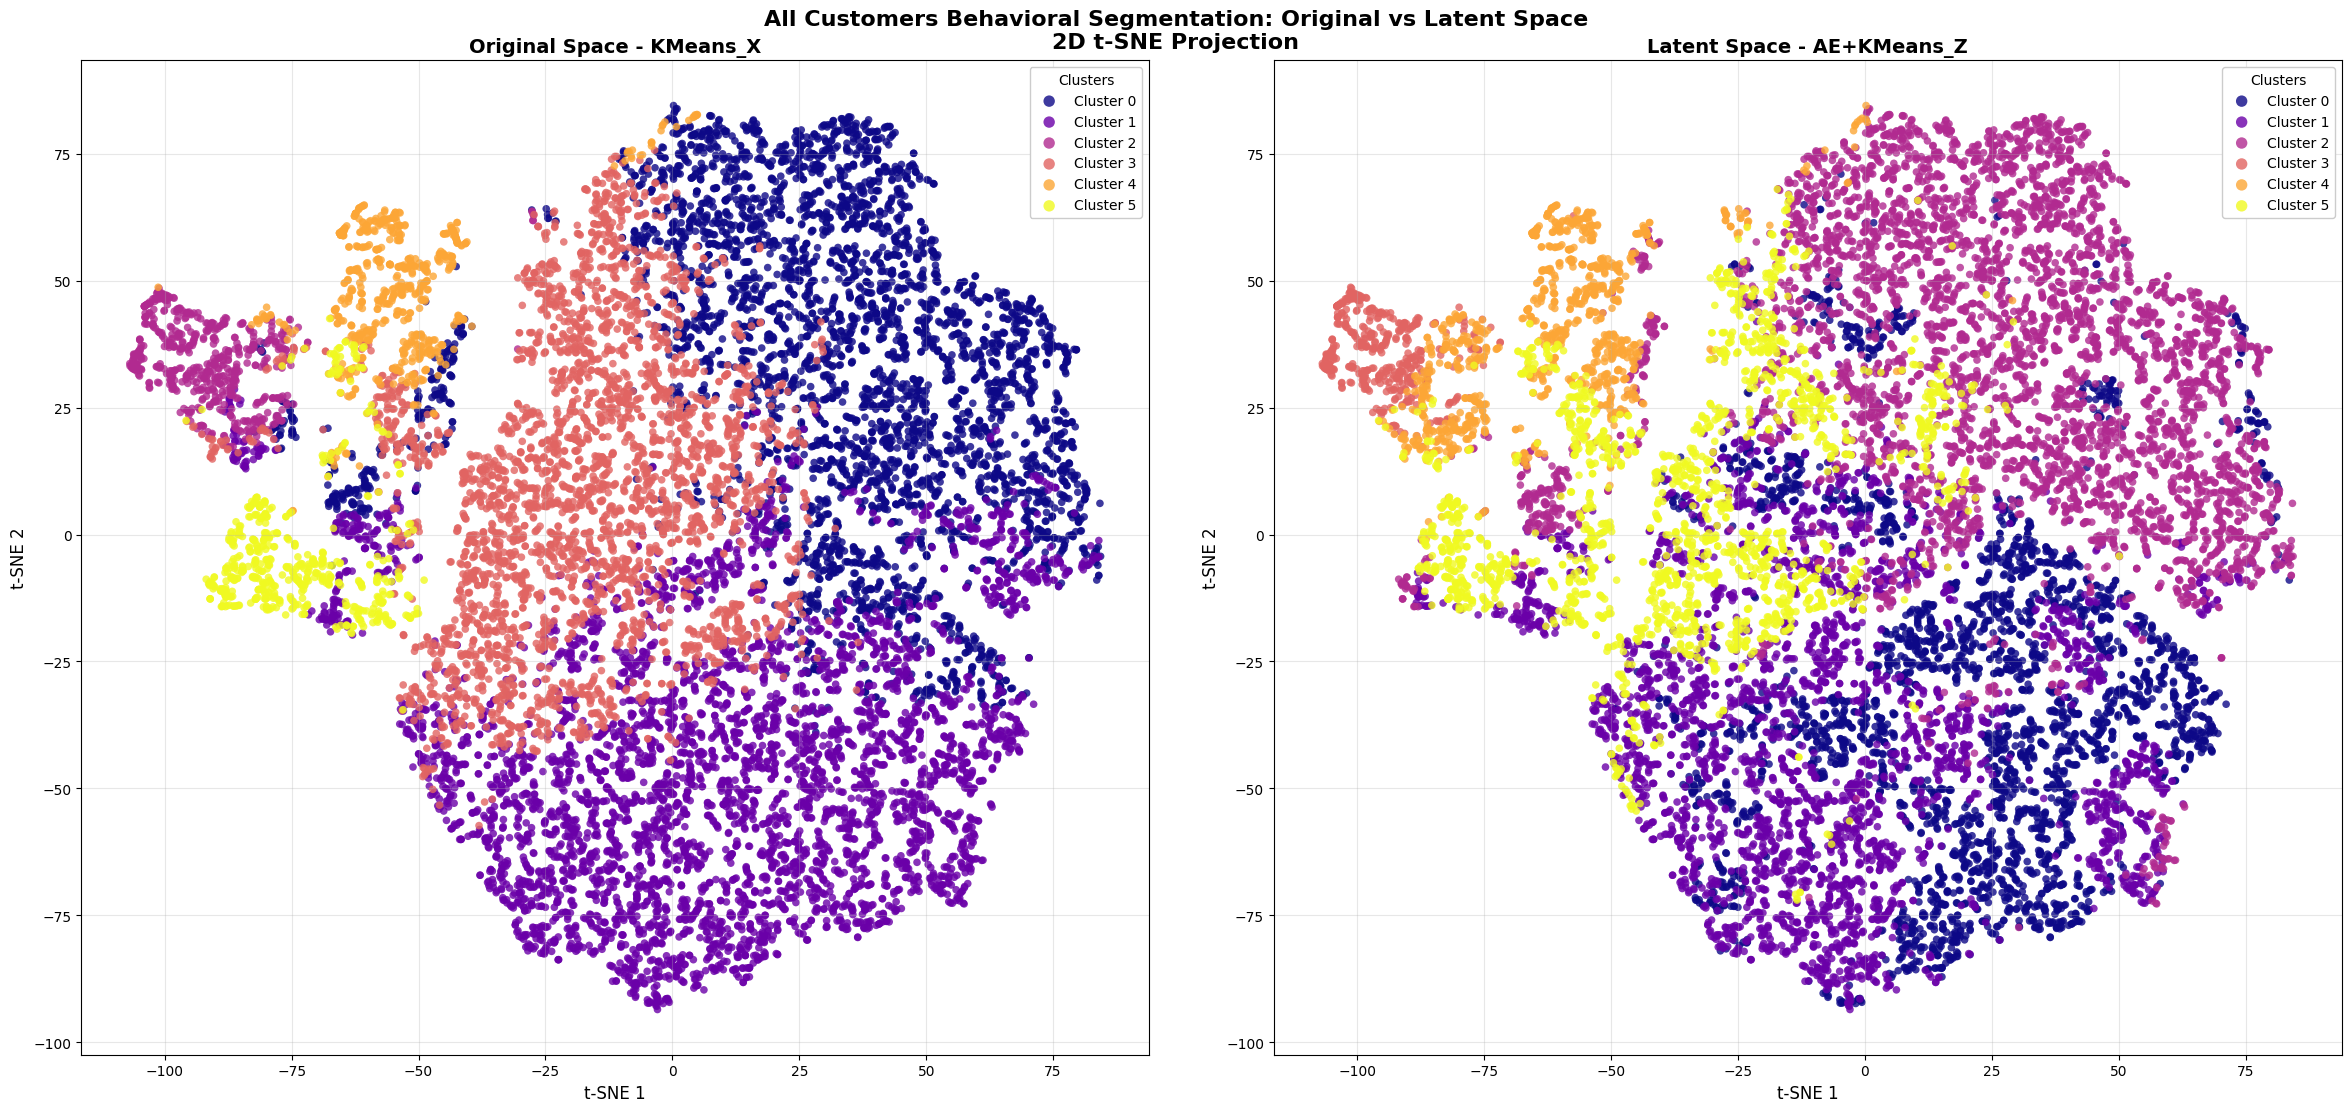

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(24, 11))

colors = cm.plasma(np.linspace(0, 1, 6))

# --- KMeans_X ---
for label in sorted(np.unique(aekmeans_labels_all_beh_X)):
    mask = aekmeans_labels_all_beh_X == label
    axes[0].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('t-SNE 1', fontsize=12)
axes[0].set_ylabel('t-SNE 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X', fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z ---
for label in sorted(np.unique(aekmeans_labels_all_beh)):
    mask = aekmeans_labels_all_beh == label
    axes[1].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('t-SNE 1', fontsize=12)
axes[1].set_ylabel('t-SNE 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Latent Space - AE+KMeans_Z', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('All Customers Behavioral Segmentation: Original vs Latent Space\n2D t-SNE Projection', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [38]:
umap_2d = UMAP(n_components = 2 , init = 'random', n_neighbors = 50, random_state = 1)
umap_2d_data = umap_2d.fit_transform(df_all[behavioral_segmentation])

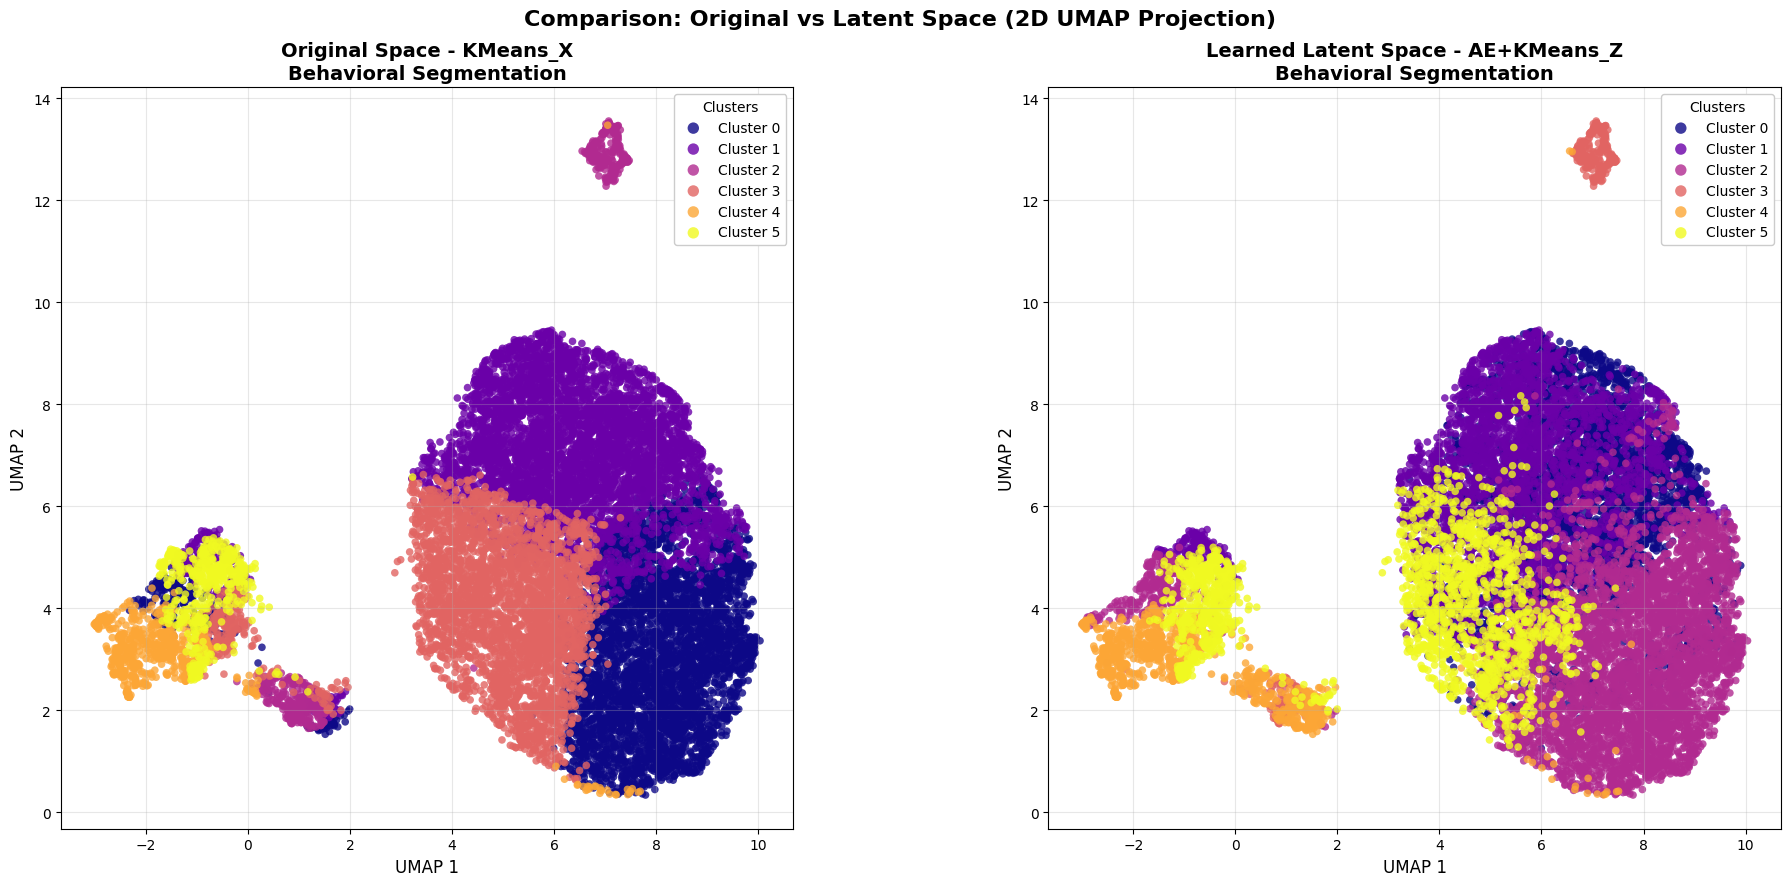

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# --- KMeans_X (Original Space) ---
for label in sorted(np.unique(aekmeans_labels_all_beh_X)):
    mask = aekmeans_labels_all_beh_X == label
    axes[0].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X\nBehavioral Segmentation', 
                 fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z (Latent Space) ---
for label in sorted(np.unique(aekmeans_labels_all_beh)):
    mask = aekmeans_labels_all_beh == label
    axes[1].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Learned Latent Space - AE+KMeans_Z\nBehavioral Segmentation', 
                 fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('Comparison: Original vs Latent Space (2D UMAP Projection)', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

Left - Original Space:

- `All Clusters` are mixed up in the left group of customers and the border lines are unclear.

- However, `Clusters 0, 1 and 3` are well separeted in the group on the right.

- `Cluster 2` is divided in two and those segments are really spread from each other.

Right - Latent Learned Space:

- Theres now a more clear division on the left group of customers. However, for that, clusters of the group on the right are overlapping a lot more.

`Note`: The colors changed from the graph on the left to the one on the right and consequently the clusters numbers. For a better understanding, clusters that correspond to the same space are gonna be explained in the same order

<a class="anchor" id="3.2">

### **3.2. Active Customers**

[Back to TOP](#TOP)
</a>

<a class="anchor" id="3.2.1">

#### **3.2.1 Value Segmentation**

[Back to TOP](#TOP)
</a>

In [40]:
tsne = TSNE(n_components=2, random_state=1, perplexity=30, max_iter=1000, learning_rate='auto', init='random')
tsne_data = tsne.fit_transform(df_active[value_segmentation])

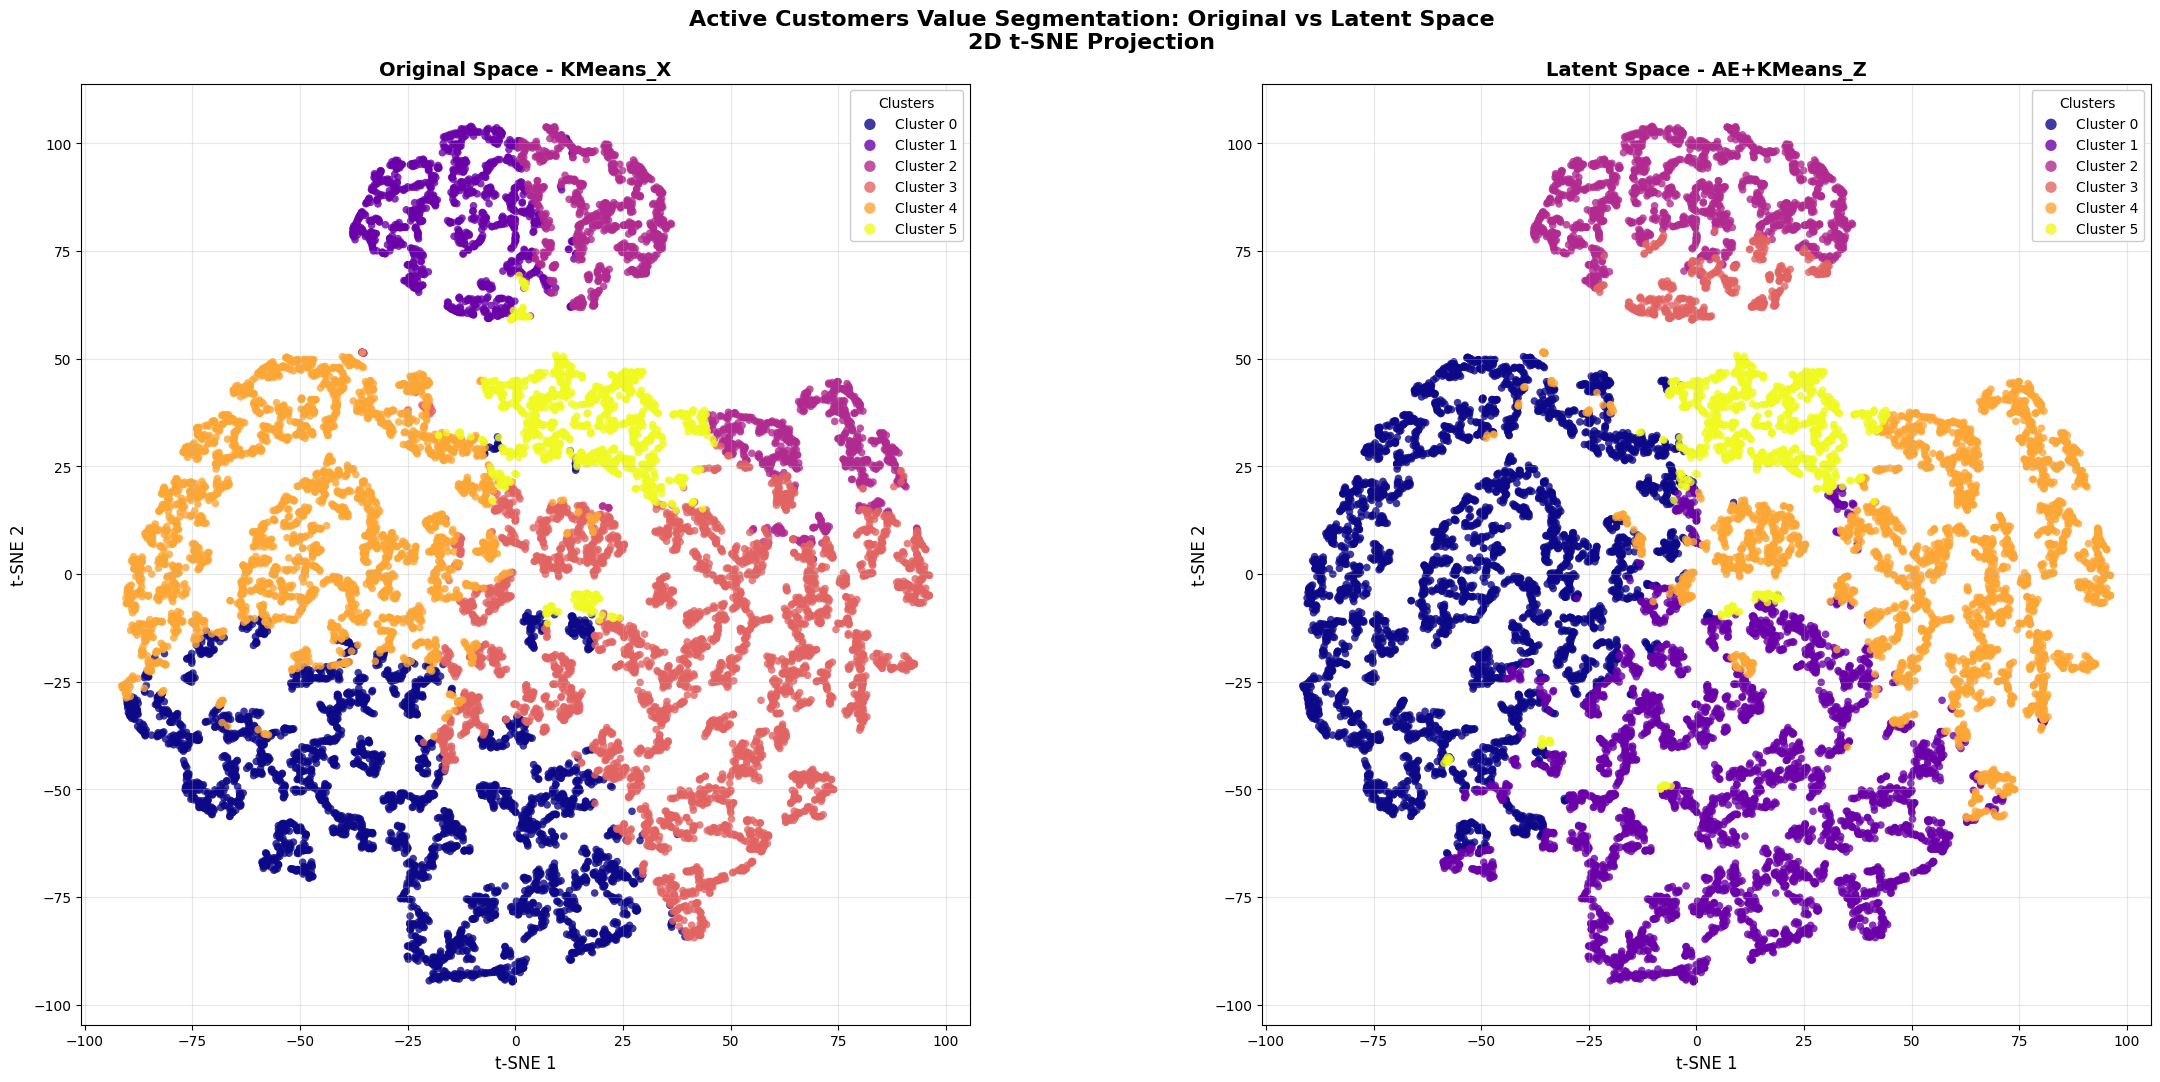

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(24, 11))

colors = cm.plasma(np.linspace(0, 1, 6))

# --- KMeans_X ---
for label in sorted(np.unique(aekmeans_labels_act_val_X)):
    mask = aekmeans_labels_act_val_X == label
    axes[0].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('t-SNE 1', fontsize=12)
axes[0].set_ylabel('t-SNE 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X', fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z ---
for label in sorted(np.unique(aekmeans_labels_act_val)):
    mask = aekmeans_labels_act_val == label
    axes[1].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('t-SNE 1', fontsize=12)
axes[1].set_ylabel('t-SNE 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Latent Space - AE+KMeans_Z', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('Active Customers Value Segmentation: Original vs Latent Space\n2D t-SNE Projection', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [42]:
umap_2d = UMAP(n_components = 2 , init = 'random', n_neighbors = 50, random_state = 1)
umap_2d_data = umap_2d.fit_transform(df_active[value_segmentation])

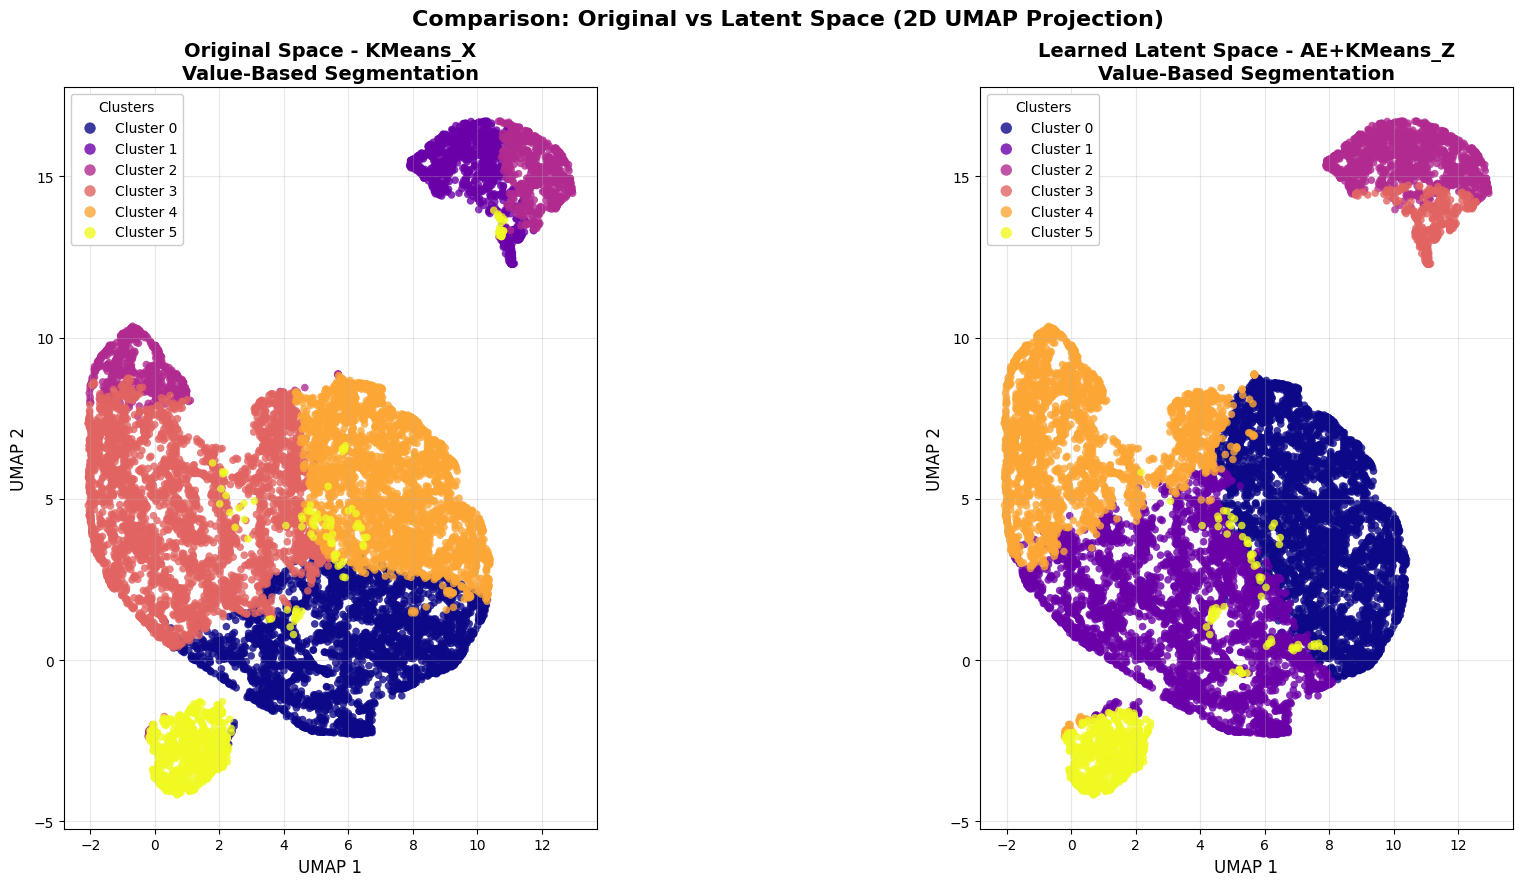

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# --- KMeans_X (Original Space) ---
for label in sorted(np.unique(aekmeans_labels_act_val_X)):
    mask = aekmeans_labels_act_val_X == label
    axes[0].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X\nValue-Based Segmentation', 
                 fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z (Latent Space) ---
for label in sorted(np.unique(aekmeans_labels_act_val)):
    mask = aekmeans_labels_act_val == label
    axes[1].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Learned Latent Space - AE+KMeans_Z\nValue-Based Segmentation', 
                 fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('Comparison: Original vs Latent Space (2D UMAP Projection)', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

Left - Original Space:

- `4 Clusters` are created in this big group of customers in the middle.

- `Cluster 2` is divided in two small segments. 

- `Cluster 5` has some spread out customers mixed with the big group in the middle.

Right - Latent Learned Space:

- `Clusters 0, 1 and 4` are now the predominant ones in the middle group. The fourth one (previously cluster 2), merged into only one segment.

- `Cluster 5`, still has some customers spread in the big group, however there are less. 

- We can clearly see an improvement here from the Original Space to the Latent Space.

`Note`: The colors changed from the graph on the left to the one on the right and consequently the clusters numbers. For a better understanding, clusters that correspond to the same space are gonna be explained in the same order

<a class="anchor" id="3.2.2">

#### **3.2.2 Behavioral Segmentation**

[Back to TOP](#TOP)
</a>

In [44]:
tsne = TSNE(n_components=2, random_state=1, perplexity=30, max_iter=1000, learning_rate='auto', init='random')
tsne_data = tsne.fit_transform(df_active[behavioral_segmentation])

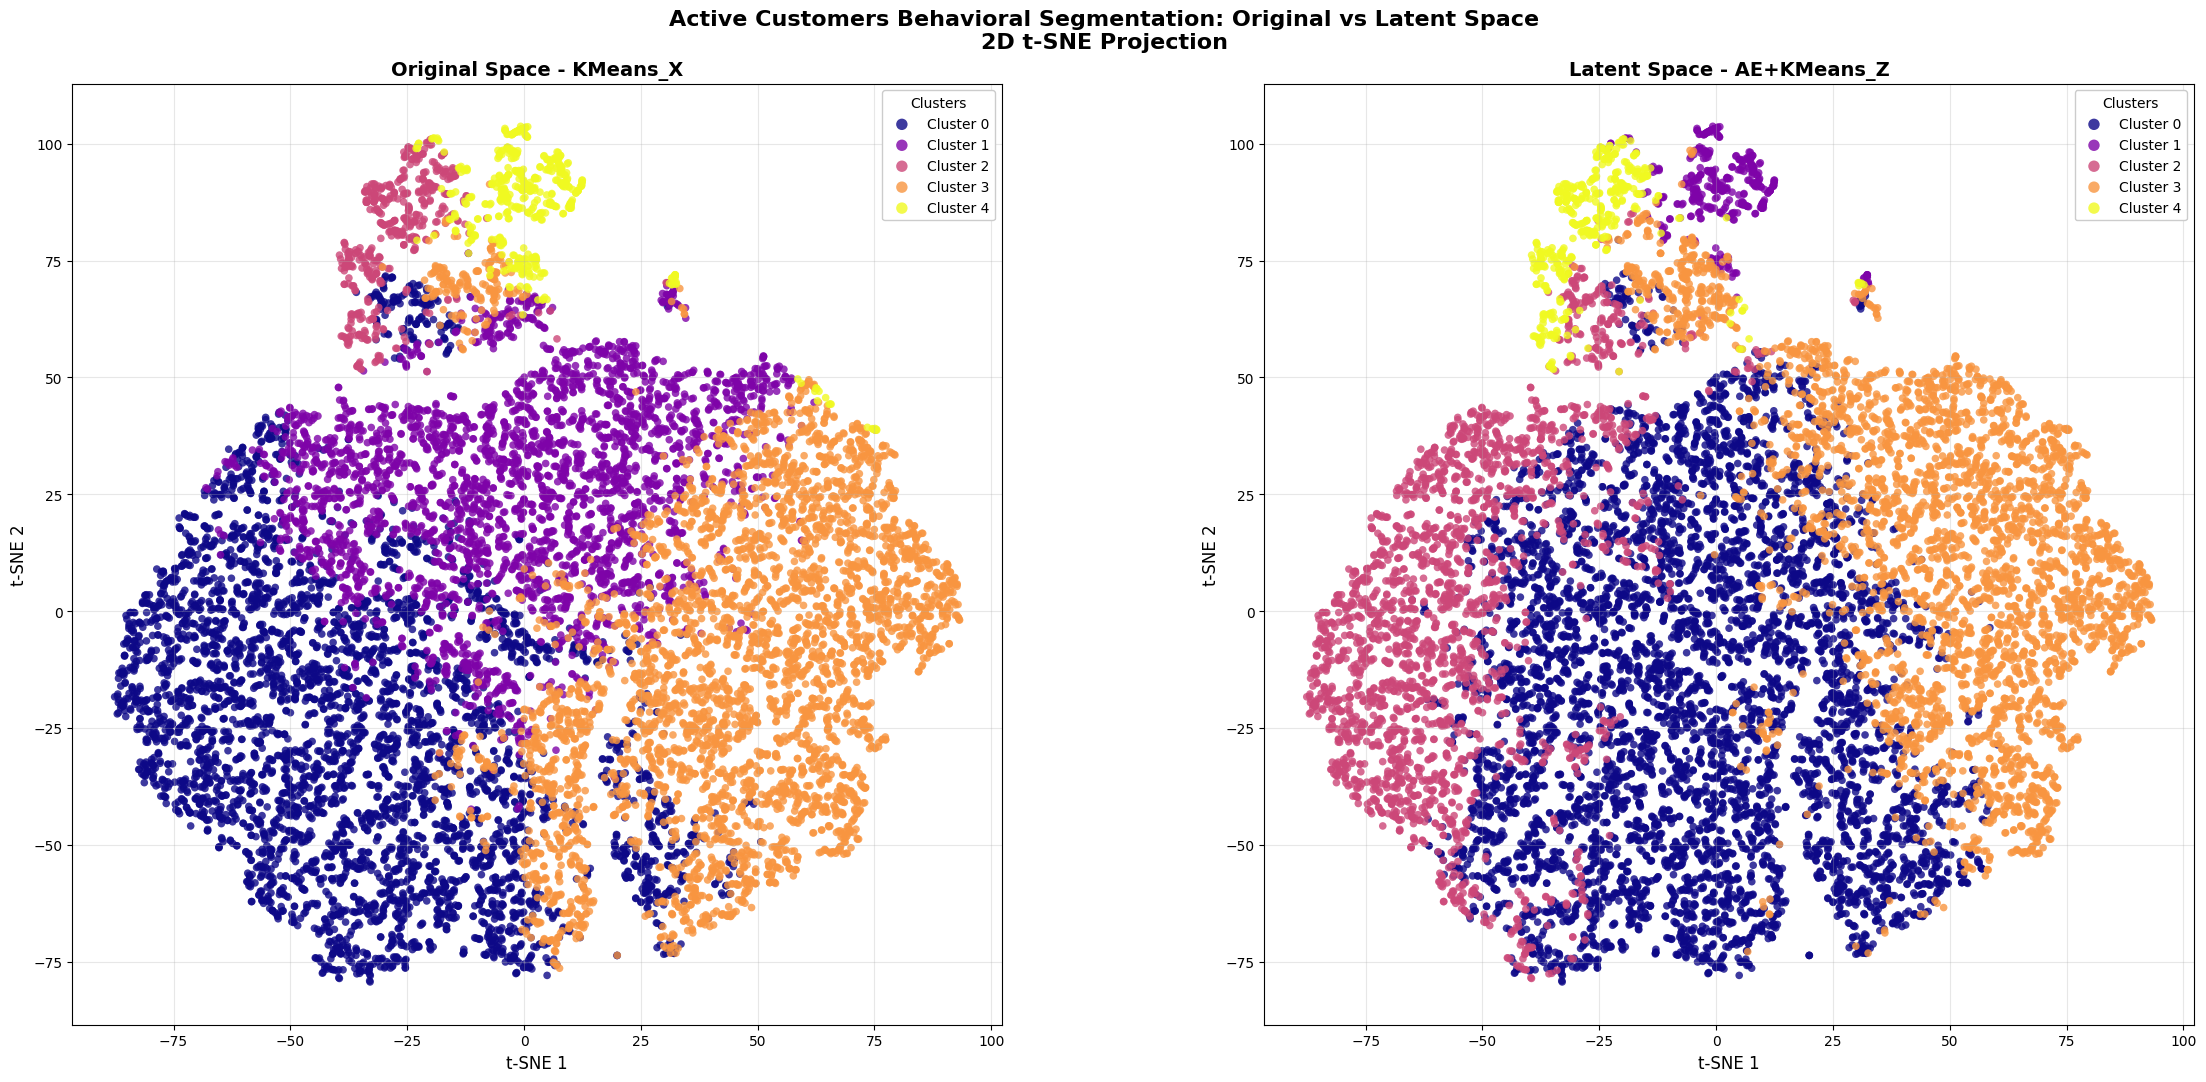

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(24, 11))

colors = cm.plasma(np.linspace(0, 1, 5))

# --- KMeans_X ---
for label in sorted(np.unique(aekmeans_labels_act_beh_X)):
    mask = aekmeans_labels_act_beh_X == label
    axes[0].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('t-SNE 1', fontsize=12)
axes[0].set_ylabel('t-SNE 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X', fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z ---
for label in sorted(np.unique(aekmeans_labels_act_beh)):
    mask = aekmeans_labels_act_beh == label
    axes[1].scatter(tsne_data[mask, 0], tsne_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('t-SNE 1', fontsize=12)
axes[1].set_ylabel('t-SNE 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Latent Space - AE+KMeans_Z', fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('Active Customers Behavioral Segmentation: Original vs Latent Space\n2D t-SNE Projection', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [46]:
umap_2d = UMAP(n_components = 2 , init = 'random', n_neighbors = 50, random_state = 1)
umap_2d_data = umap_2d.fit_transform(df_active[behavioral_segmentation])

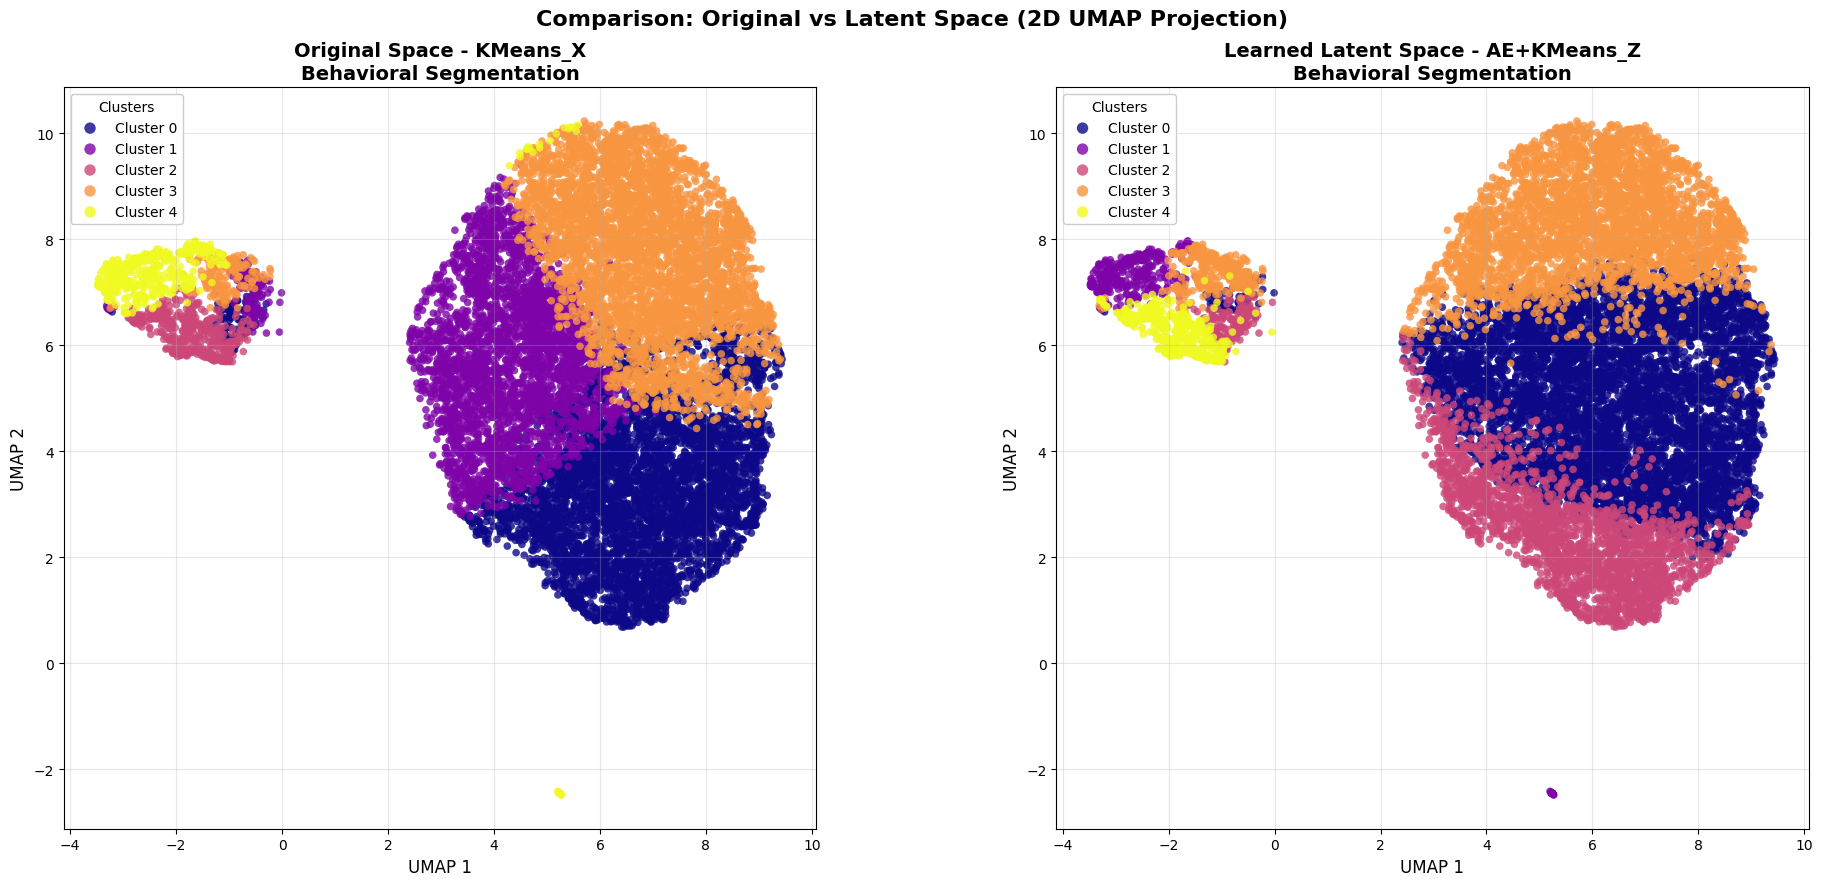

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# --- KMeans_X (Original Space) ---
for label in sorted(np.unique(aekmeans_labels_act_beh_X)):
    mask = aekmeans_labels_act_beh_X == label
    axes[0].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[0].set_title('Original Space - KMeans_X\nBehavioral Segmentation', 
                 fontsize=14, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

# --- AE+KMeans_Z (Latent Space) ---
for label in sorted(np.unique(aekmeans_labels_act_beh)):
    mask = aekmeans_labels_act_beh == label
    axes[1].scatter(umap_2d_data[mask, 0], umap_2d_data[mask, 1], 
                   c=[colors[label]], alpha=0.8, s=30, edgecolors='none', 
                   label=f'Cluster {label}')

axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].legend(loc='best', framealpha=1, title='Clusters', fontsize=10, markerscale=1.5)
axes[1].set_title('Learned Latent Space - AE+KMeans_Z\nBehavioral Segmentation', 
                 fontsize=14, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal')

plt.suptitle('Comparison: Original vs Latent Space (2D UMAP Projection)', 
            fontsize=16, weight='bold', y=0.98)
plt.tight_layout()
plt.show()

Left - Original Space:

- `Cluster 0` is overlapping with `Cluster 1 and 3`. They show no clear boundaries.

- `4 Clusters` on the small left group are overlapping a lot aswell, specially `Clusters 1, 2 and 4`.

Right - Latent Learned Space:

- `Clusters 0, 1 and 3` 

- In the small group on the left, we can see a trial for setting boundaries but still not very successfull with the same `4 Clusters`, in this case, `Clusters 1, 2, 3 and 4`. 

`Note`: The colors changed from the graph on the left to the one on the right and consequently the clusters numbers. For a better understanding, clusters that correspond to the same space are gonna be explained in the same order